# Hate Speech Classification with a Long-Short Term Memory Model

The Long-Short Term Memory (LSTM) model is an improvement on the Recurrent Neural Network (RNN) architecture. A RNN processes each element of the input sequentially and updates its parameters using a variation of backpropagation known as backpropagation through time (BPTT). BPTT unrolls the time steps, applies backpropagation and rolls the recurrent structure back up. RNNs are unable to capture a consetual representation of long sequences of data as they have no long term memory. This makes them instable and inefficient as they commonly suffer with vanishing/exploding gradients, halting the learning process.

LSTMs work differently. Each LSTM module contains a cell state and a hidden state. The cell state allows a representation of the data to run through the model and undergo updates via linear instructions determined by internal gates. There is a forget gate; used to discard information, an input gate to add new information and an output gate which finalises the state of the module. By maintaining a consistent cell state, gradients flow easily through the network, mitigating the vanishing/exploding gradient problem in most cases. Compared to RNNs, LSTMs have significantly better stability and memory. 

## Imports

In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch import nn
from collections import Counter
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns
from wordcloud import WordCloud
import wandb

sns.set()

## Data PreProcessing

Each of the six datasets are formatted differently. This cell is used to standardise and strip them of unnecessary data, reducing them to `label` and `text` columns.
These datasets are then concatenated to form one large dataset.

Data sources:
- https://kaggle.com/datasets/kazanova/
- https://hasocfire.github.io/hasoc/2021/dataset.html
- https://figshare.com/articles/dataset/Labelled_Hate_Speech_Detection_Dataset_/19686954
- https://zenodo.org/record/3706866
- https://kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset
- https://kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset

In [2]:
df = pd.read_csv(
    'Data/Unprocessed/training.1600000.processed.noemoticon.csv', 
    encoding='latin', 
    header=None
    )
df.columns = ['label', 'id', 'date', 'query', 'user_id', 'text']
df = df.drop(columns=['id', 'date', 'query', 'user_id'])

df['label'].mask(df['label'] == 0, 1, inplace=True)
df['label'].mask(df['label'] == 2, 0, inplace=True)
df['label'].mask(df['label'] == 4, 0, inplace=True)

df_2 = pd.read_csv(
    'Data/Unprocessed/hasoc_english_dataset.tsv', 
    delimiter='\t'
    )
df_2 = df_2.drop(columns=['text_id', 'task_1', 'task_3'])
df_2 = df_2.rename(columns={'task_2': 'label'})

df_2['label'].mask(df_2['label'] == 'HATE', 1, inplace=True)
df_2['label'].mask(df_2['label'] == 'OFFN', 1, inplace=True)
df_2['label'].mask(df_2['label'] == 'PRFN', 1, inplace=True)
df_2['label'].mask(df_2['label'] == 'NONE', 0, inplace=True)

df_3 = pd.read_csv('Data/Unprocessed/HateSpeechDetection.csv')
df_3 = df_3.drop(columns=['Platform'])
df_3 = df_3.rename(columns={'Comment': 'text'})
df_3 = df_3.rename(columns={'Hateful': 'label'})

df_4 = pd.read_csv(
    'Data/Unprocessed/hatespeech_text_label_vote_RESTRICTED_100K.csv'
    )
df_4 = df_4.drop(columns=['Votes for the majority label'])
df_4 = df_4.rename(columns={'Tweet text': 'text'})
df_4 = df_4.rename(columns={'Label': 'label'})

df_4['label'].mask(df_4['label'] == 'normal', 0, inplace=True)
df_4['label'].mask(df_4['label'] == 'spam', 0, inplace=True)
df_4['label'].mask(df_4['label'] == 'abusive', 1, inplace=True)
df_4['label'].mask(df_4['label'] == 'hateful', 1, inplace=True)
df_4['text'] = df_4['text'].str.replace('RT', '')

df_5 = pd.read_csv('Data/Unprocessed/FinalBalancedDataset.csv')
df_5.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
df_5.drop(["a"], axis=1, inplace=True)
df_5 = df_5.rename(columns={'Toxicity': 'label'})
df_5 = df_5.rename(columns={'tweet': 'text'})
df_5['text'] = df_5['text'].str.replace('ð', '')

df_6 = pd.read_csv('Data/Unprocessed/Reddit_Data.csv')
df_6 = df_6.rename(columns={'clean_comment': 'text'})
df_6 = df_6.rename(columns={'category': 'label'})
df_6.drop(df_6[df_6['label'] == 0].index, inplace=True)
df_6 = df_6[df_6['text'] != '']
df_6['label'].mask(df_6['label'] == 1, 0, inplace=True)
df_6['label'].mask(df_6['label'] == -1, 1, inplace=True)

"""
Concatenate datasets
"""

processed_data = pd.concat([df, df_2, df_3, df_4, df_5, df_6])

processed_data['text'] = processed_data['text'].str.replace('https', '')
processed_data['text'] = processed_data['text'].str.replace('t', '')
processed_data['text'] = processed_data['text'].str.replace('co', '')
processed_data['text'] = processed_data['text'].str.replace('amp', '')
processed_data['text'] = processed_data['text'].str.replace('quo', '')

# save all data
processed_data.to_csv('Data/processed_data.csv')
print(len(processed_data))
processed_data.head()

1789694


,label,text
0,1,"@swichfoo hp://wipic.m/2y1zl - Awww, ha's a bu..."
1,1,is upse ha he can' updae his Facebook by exing...
2,1,@Kenichan I dived many imes for he ball. Manag...
3,1,my whole body feels ichy and like is on fire
4,1,"@naionwideclass no, i's no behaving a all. i'm..."


## Word Clouds

(-0.5, 399.5, 299.5, -0.5)

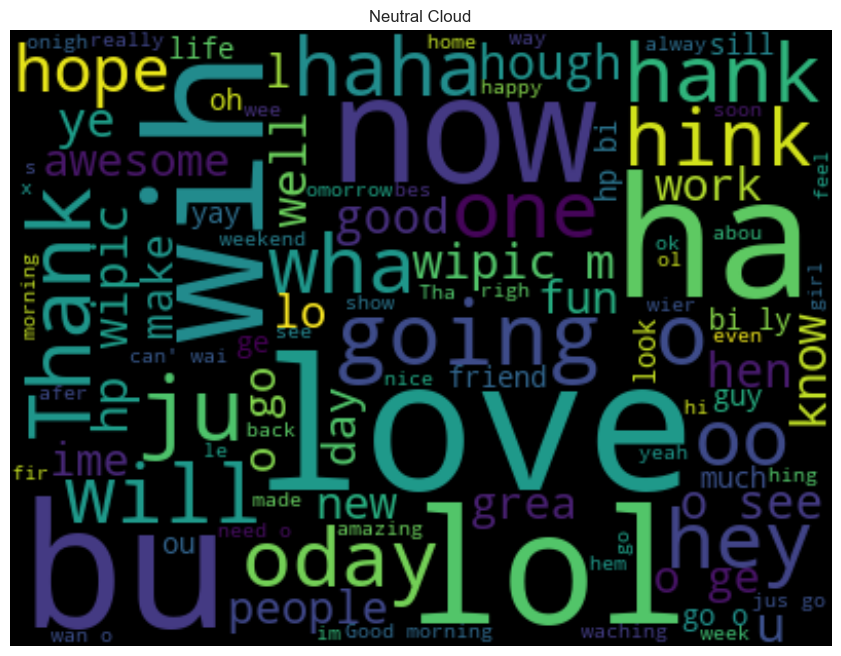

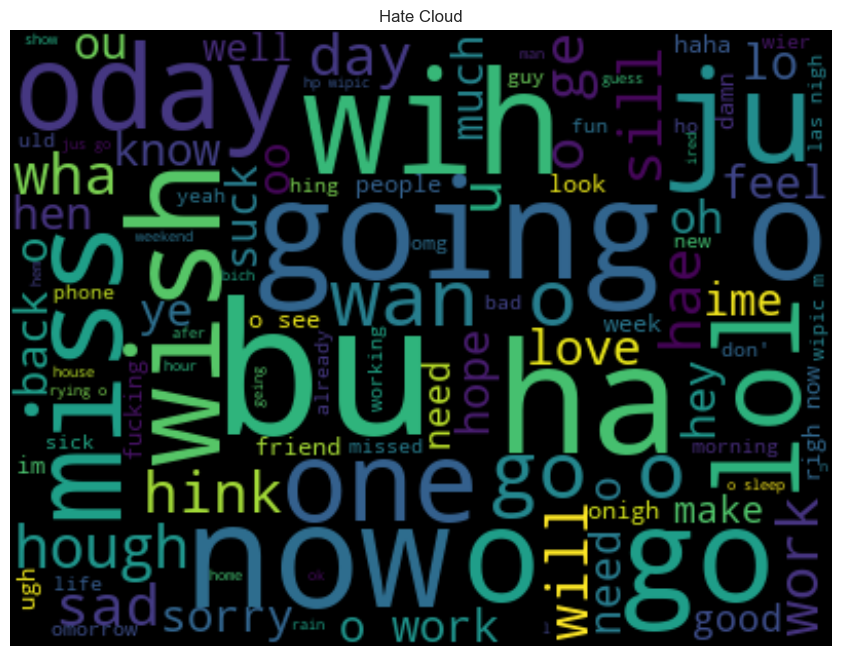

In [3]:
neutral_words = ' '.join([word for word in processed_data['text'][processed_data['label'] == 0]])

neutral_cloud = WordCloud(width=400, height=300, max_font_size=90, max_words=100).generate(neutral_words)
plt.figure(figsize=(12, 8))
plt.imshow(neutral_cloud, interpolation='bilinear', cmap='plasma')
plt.title('Neutral Cloud')
plt.axis('off')

hate_words = ' '.join([word for word in processed_data['text'][processed_data['label'] == 1]])

hate_cloud = WordCloud(width=400, height=300, max_font_size=90, max_words=100).generate(hate_words)
plt.figure(figsize=(12, 8))
plt.imshow(hate_cloud, interpolation='bilinear', cmap='plasma')
plt.title('Hate Cloud')
plt.axis('off')

## Create Datasets

The total dataset is very large, containing 1,789,694 items. Training a model on this many items takes a long time so in order to make the training process more manageable the dataset is being split into 8 subsets.
Training the model for a long time to discover it overfits of underfits the data is not ideal. The model can be trained on subsets periodically, streamlining the process and enabling better control over how the model updates its parameters.

Each subset is split into a training, validation and test set.

In [4]:
def train_val_test_split(data):
    """
    Splits a dataset into train/val/test sets.
    
    - 81% Training data
    - 9% Validation data
    - 10% Testing data

    Args:
        data (DataFrame): DataFrame which needs splitting.

    Returns:
        train_data, val_data, test_data 
            (DataFrame, DataFrame, DataFrame): train/va/test sets.
    """
    train_data_ = data.sample(frac=0.9)
    test_data = data.drop(train_data_.index)
    train_data = train_data_.sample(frac=0.9)
    val_data = train_data_.drop(train_data.index)
    return train_data, val_data, test_data

def dataset_details(dataset, data_name, set_name):
    """
    Displays the number of elements each class has in the dataset.

    Args:
        dataset (DataFrame): 
        data_name (str): Name of the folder e.g. 'data_1'
        set_name (str): Name of the dataset (e.g. 'Training').
    """
    num_samples = len(dataset)
    num_label_0 = Counter(dataset['label'].tolist())[0]
    num_label_1 = Counter(dataset['label'].tolist())[1]
    split_percent = num_label_1 / num_samples * 100
    print('*' + '-' * 19 + '*')
    print(f'|      {data_name:11}  |')
    print(f'|     {set_name:11}   |')
    print('|' + '-' * 19 + '|')
    print(f'| Samples : {num_samples:7} |')
    print('*' + '-' * 19 + '*')
    print(f'| Neutral : {num_label_0:6}  |')
    print(f'| Hate    : {num_label_1:6}  |')
    print(f'| Split   : {split_percent:.2f}%  |')
    print('*' + '-' * 19 + '*')
    if set_name == 'Testing':
        print('\n\n')

In [5]:
# Shuffle dataframe
processed_data = processed_data.sample(frac=1)
# Split dataframe into 8 subsets
split_data = np.array_split(processed_data, 16)
# List of subset names
data_names = ['data_1', 'data_2', 'data_3', 'data_4', 'data_5', 
    'data_6', 'data_7', 'data_8', 'data_9', 'data_10', 'data_11',
    'data_12', 'data_13', 'data_14', 'data_15', 'data_16']

"""
Iterates through the subsets and saves them to disk
Creates a training, validation and test set from each subset
Displays the label splits and saves each dataset to disk
"""
for i in range(len(split_data)):
    # reset indexes of each subset and save to disk
    split_data[i].reset_index(drop=True, inplace=True)
    split_data[i].to_csv(f'Data/Split Datasets/{data_names[i]}.csv')

    # Split subset into training, validation and test sets and save
    train, val, test = train_val_test_split(split_data[i])
    dataset_details(train, data_name=data_names[i], set_name='Training')
    dataset_details(val, data_name=data_names[i], set_name='Validation')
    dataset_details(test, data_name=data_names[i], set_name='Testing')
    train.to_csv(f'Data/Split Datasets/{data_names[i]}/train.csv')
    val.to_csv(f'Data/Split Datasets/{data_names[i]}/val.csv')
    test.to_csv(f'Data/Split Datasets/{data_names[i]}/test.csv')
    

*-------------------*
|      data_1       |
|     Training      |
|-------------------|
| Samples :   90603 |
*-------------------*
| Neutral :  46682  |
| Hate    :  43921  |
| Split   : 48.48%  |
*-------------------*
*-------------------*
|      data_1       |
|     Validation    |
|-------------------|
| Samples :   10067 |
*-------------------*
| Neutral :   5173  |
| Hate    :   4894  |
| Split   : 48.61%  |
*-------------------*
*-------------------*
|      data_1       |
|     Testing       |
|-------------------|
| Samples :   11186 |
*-------------------*
| Neutral :   5786  |
| Hate    :   5400  |
| Split   : 48.27%  |
*-------------------*



*-------------------*
|      data_2       |
|     Training      |
|-------------------|
| Samples :   90603 |
*-------------------*
| Neutral :  46627  |
| Hate    :  43976  |
| Split   : 48.54%  |
*-------------------*
*-------------------*
|      data_2       |
|     Validation    |
|-------------------|
| Samples :   10067 |
*------

## Collate Batches and Initialise DataLoaders

Collates `label`/`text` pairs into tuples, where the text is transformed into its GloVe embedding. Sequences are padded and tensors are moved to the specified device. 

Batches are padded so they are all the same length. 

Used by DataLoaders to shuffle data each epoch and process the data using the pipeline described above.


In [6]:
def collate_batch(batch, embeddings, dimensions, device):
    """
    Custom collate function to prepare batches for LSTM processing.
    Ensures the label is an integer and transforms the input sequence
        to its vector embedding.
    
    Args:
        batch (numpy.array): List of tuples containing label/text pairs.
        embeddings (dict): Dictionary of word/vector embedding pairs.
        dimensions (int): Dimensions used for embedding vector.
        device (torch.device): Device used to process tensors.

    Returns:
        label_list, text_list, text_lengths 
        (torch.Tensor, torch.Tensor, torch.Tensor): 
            Tensors of labels, padded embeddings and text lengths.
    """
    # Containers for labels and text embeddings.
    label_list, text_list = [], []
    for (label, text) in batch:
        # Stores the label as an integer
        label_list.append(int(label))
        embedding = []
        for word in text.split():
            # If word doesn't exist return vector of 0's.
            vector = embeddings.get(word, np.zeros((dimensions,)))
            # Convert embedding to tensor.
            embedding.append(torch.tensor(vector, dtype=torch.float32))
        # Store embedded sequence in text_list
        text_list.append(torch.stack(embedding))
    # Convert labels to tensors.
    label_list = torch.tensor(label_list, dtype=torch.int64)
    # Pad all sequences to same as longest sequence length.
    text_list = rnn_utils.pad_sequence(text_list, batch_first=True)
    # Create tensor storing length of sequences.
    text_lengths = torch.tensor([len(t) for t in text_list], dtype=torch.int64)
    # Move data to specified device (GPU/CPU).
    return label_list.to(device), text_list.to(device), text_lengths.to(device)


def batch_padding(batch_size, embeddings, dimensions, device):
    """
    Pads batches to specified size then processes using `collate_fn()`. 
    Pads by repeating the last element until batch_size is reached.

    Args:
        batch_size (int): The size of each batch.
        embeddings (dict): Dictionary of word embeddings.
    
    Returns:
        collate_fn (function): Function to pad a batch and 
            processes it `collage_batch()`
    """
    def collate_fn(batch, dimensions=dimensions):
        padded_batch = batch + [batch[-1]] * (batch_size - len(batch))
        return collate_batch(padded_batch, embeddings, dimensions, device)
    return collate_fn

## Vocabulary and DataLoaders

GloVe (Global Vectors for Word Representation) embeddings are dense vector
representations of words. Vector values represent a multidimensional map of semantic, syntactic and other linguistic attributes of words.

Returns the embeddings as a dictionary of word/vector pairs.
Defines process of creating DataLoaders from a dataset.


In [7]:
def set_device():
    """
    Device used to process tensors.
    """
    if torch.backends.mps.is_available():
        if torch.backends.mps.is_built():
            print('Using MPS')
            return torch.device("mps")
    else:
        return torch.device("cpu")

def glove_embedding_dict(file):
    """
    Produces a dictionary of word/GloVe embeddings.

    Args:
        file (str): Path to GloVe embeddings file.

    Returns:
        embedding_dict (dict): word/GloVe embeddings.
    """
    embedding_dict = {} 

    with open(file, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embedding_dict[word] = vector
    return embedding_dict

def init_dataloaders(folder, 
                     embedding_dict, 
                     batch_size, 
                     dimensions, 
                     device):
    """
    Creates train/val/test DataLoaders.

    Args:
        folder (str): train/val/test csv within 'Data/Split Datasets/'. 
        embedding_dict (dict): word/GloVe embeddings
        batch_size (int): Batch size
        dimensions (int): Dimensions of data. Used for padding batches.
        device (torch.device): Device used to process data.

    Returns:
        train_loader, val_loader, test_loader
            (DataLoader, DataLoader, DataLoader): Required DataLoaders.
    """
    train = pd.read_csv(
        f'Data/Split Datasets/{folder}/train.csv'
        ).drop(columns=['Unnamed: 0'])
    val = pd.read_csv(
        f'Data/Split Datasets/{folder}/val.csv'
        ).drop(columns=['Unnamed: 0'])
    test = pd.read_csv(
        f'Data/Split Datasets/{folder}/test.csv'
        ).drop(columns=['Unnamed: 0'])

    train = train.to_numpy()
    val = val.to_numpy()
    test = test.to_numpy()

    train_loader = DataLoader(
        train, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=batch_padding(batch_size, embedding_dict, dimensions, device)
        )
        
    val_loader = DataLoader(
        val, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=batch_padding(batch_size, embedding_dict, dimensions, device)
        )

    test_loader = DataLoader(
        test, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=batch_padding(batch_size, embedding_dict, dimensions, device)
        )

    return train_loader, val_loader, test_loader

## Training and Evaluation Functions

A training function allows the model to make predictions and 'learn' through trial and error.
The evaluation function is used to asses the models performance on unseen data. The model is unable to learn from this data so it's used to repeatedly test the model.

An evaluation is performed after every epoch (pass through the training data) so changes in perfomance can be seen in real time.

`plot_metrics` is defined which displays the metrics visually.

In [8]:
def plot_metrics(t_metric, v_metric, metric, num_epochs):
    """
    Displays accuracy and validation metrics plotted on line graphs.

    Args:
        t_metric (list): Accuracy/loss values during training.
        v_metric (list): Accuracy/loss values during validation.
        metric (str): Type of metric being plotted
        num_epochs (int): Number of epochs the model was trained.
    """
    plt.plot(t_metric, c='blue', label=f'Training')
    plt.plot(v_metric, c='red', label=f'Validation')
    plt.ylabel(f'{metric.title()}')
    plt.xlabel('Epoch')
    plt.title(f'{metric.title()} over {num_epochs} epochs')
    plt.legend()
    plt.show()

def train(dataloader, 
          model, 
          optimizer, 
          scheduler, 
          criterion, 
          epoch, 
          verbose=True):
    """
    Used to train a neural network.
    Sets the model to training mode and initialises variables to keep 
    track of metrics during training.
    Iterates through label/text pairs from each dataset making label
    predictions. 
    Calculates loss and backpropagates parameter updates
    through the network to ideally reduce loss over epochs.

    Args:
        dataloader (DataLoader): DataLoader containing training
            data.
        model (nn.Module): The LSTM model being trained.
        optimizer (torch.optim.sgd): Backpropagation method.
        criterion (torch.nn.modules.loss): Loss function.
        epoch (int): The current epoch.
        verbose (Boolean): Display metrics (default=True).

    Returns:
        epoch_loss, epoch_accuracy, epoch_count 
            (float, float, int): loss, accuracy and number of 
            predictions made in one epoch.
    """
    model.train()
    # Accuracy and loss accumulated over epoch
    total_correct, total_loss = 0, 0
    # Number of predictions
    num_predictions = 0
    # Displays training metrics every quarter of epoch
    intervals = (len(dataloader) / 4).__round__()
    for idx, (label, text, text_lengths) in enumerate(dataloader):
        # Make prediction
        prediction = model(text, text_lengths)
        label = label.unsqueeze(1)
        # Calculate loss
        loss = criterion(prediction, label.float())
        batch_loss = loss.item()
        # Update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Store metrics
        correct_predictions = ((prediction > 0.5) == label).sum().item()
        total_loss += batch_loss
        total_correct += correct_predictions
        num_predictions += label.size(0)

        if verbose and idx % intervals == 0 and idx > 0:
            current_accuracy = (total_correct / num_predictions) * 100
            epoch_metrics = (
                f'| Epoch {epoch + 1} |' 
                f'{idx:5} / {len(dataloader):5} batches |' 
                f'{current_accuracy:.10f}% accurate |'
                )
            print(epoch_metrics)
    scheduler.step()
    # Loss per batch
    avg_loss_pct = total_loss / len(dataloader)
    # Percentage of accurate predictions
    avg_accuracy_pct = (total_correct / num_predictions) * 100
    return avg_loss_pct, avg_accuracy_pct

def evaluate(dataloader, model, criterion):
    """
    Used to evaluate model training.
    Works similarly to the training method, allowing the model
    to make predictions on labelled data, however no parameters are
    updated.

    Args:
        dataloader (DataLoader): DataLoader containing either validation
            or testing data.
        model (nn.Module): The LSTM model being trained.
        criterion (torch.nn.modules.loss): Loss function.

    Returns:
        batch_loss, batch_accuracy, batch_count 
            (float, float, int): loss, accuracy and number of 
            predictions made over the validation set.
    """
    model.eval()
    correct_predictions = 0
    total_correct = 0
    num_predictions = 0
    total_loss = 0
    with torch.no_grad():
        for idx, (label, text, text_length) in enumerate(dataloader):
            prediction = model(text, text_length)
            label = label.unsqueeze(1)
            loss = criterion(prediction, label.float())
            correct_predictions += ((prediction > 0.5) == label).sum().item()
            num_predictions += label.size(0)
            total_loss += loss.item()
            total_correct += correct_predictions
            correct_predictions = 0
    # Loss per batch
    avg_loss_pct = total_loss / len(dataloader)
    # Percentage of accurate predictions
    avg_accuracy_pct = (total_correct / num_predictions) * 100
    return avg_loss_pct, avg_accuracy_pct

def model_env(training, 
              validation, 
              testing, 
              model, 
              optimizer,
              scheduler, 
              criterion, 
              epochs, 
              verbose=True):
    """
    Wraps the training and evaluation functions in one method.
    At the end of each epoch, the model asseses the validation set.
    Once all epochs are complete performance is assesed on the test set.

    Args:
        training (DataLoader): DataLoader with training data.
        validation (DataLoader): DataLoader with validation data.
        testing (DataLoader): DataLoader with testing data.
        model (nn.Module): The LSTM model being trained.
        optimizer (torch.optim.sgd): Backpropagation method.
        criterion (torch.nn.modules.loss): Loss function.
        epochs (int): Number of epochs the model is trained for.
        verbose (Boolean): Display metrics (default=True).

    Returns:
        train_accuracy, train_loss, val_accuracy, val_loss 
            (list, list, list, list): Metrics saved during training and
            evaluation.
    """
    # Containers for training and evaluation metrics
    train_accuracy = [] # Collection of average 
    train_loss = []
    val_accuracy = []
    val_loss = []
    # Time saved for calculating final processing time
    start_time = time.time()
    for epoch in range(epochs):
        epoch_start = time.time()
        print('-' * 59)
        print(f'|\t\t          Epoch {epoch + 1}           \t\t  |')
        print('-' * 59)
        # Process training data
        t_loss, t_acc = train(training, 
                                 model, 
                                 optimizer,
                                 scheduler, 
                                 criterion, 
                                 epoch, 
                                 verbose)  
        # Store training metrics
        train_loss.append(t_loss)
        train_accuracy.append(t_acc)
        # Evaluate validation data
        v_loss, v_acc = evaluate(validation, model, criterion)
        # Store evaluation metrics
        val_loss.append(v_loss)
        val_accuracy.append(v_acc)

        # Log metrics to wandb
        wandb.log({
        'Epoch': epoch,
        'Training Accuracy': t_acc,
        'Training Loss': t_loss,
        'Validation Accuracy': v_acc, 
        'Validation Loss': v_loss,
        })

        print('-' * 59)
        epoch_metrics = (
            f'| End of epoch {epoch + 1} |'
            f'Time: {time.time() - epoch_start:.2f}s|'
            f'Acc: {v_acc:.14f}%  |'
        )
        print(epoch_metrics)
        print('-' * 59)
        print()

    # Assess model performance on test data
    _, test_acc = evaluate(testing, model, criterion)
    total_time = (time.time() - start_time).__round__()/60
    print('*' + '-' * 57 + '*')
    test_metrics = (
        f'*\t\t\tTesting Epoch\t\t\t  *\n'
        f'*' + '-' * 57 + '*\n'
        f'* \t\t      Time: {total_time:.2f} minutes\t\t  *\n'
        f'*\t\t    Acc: {test_acc:.14f}%     \t  *'
    )
    print(test_metrics)
    print('*' + '-' * 57 + '*\n')
    wandb.finish()
    return train_accuracy, train_loss, val_accuracy, val_loss

## LSTM Model

In [9]:
class LSTM_Model(nn.Module):
    """
    LSTM model used to process and predict sentiment of
        a textual input sequence.
    Extracts data from an input sequence via LSTM modules before the 
        classifier determines an output.

    Args:
        nn (nn.Module): Base class for PyTorch neural networks.
    """
    def __init__(self, vector_dim, num_hidden_nodes, hidden_layers):
        """
        Initialises LSTM modules, the classifier, 
            batch normalisation, ReLU activation and dropout.

        Args:
            vector_dim (int): Dimensions of vector embeddings.
            num_hidden_nodes (int): Number of nodes in the LSTM module.
            hidden_layers (int): Number of hidden layers in the module.
        """
        super(LSTM_Model, self).__init__()

        self.lstm1 = nn.LSTM(input_size=vector_dim,
                    hidden_size=num_hidden_nodes*2,
                    num_layers=hidden_layers,
                    batch_first=True,
                    dropout=0.2,
                    bidirectional=True)

        self.lstm2 = nn.LSTM(num_hidden_nodes*4,
                    num_hidden_nodes*3,
                    hidden_layers,
                    bidirectional=True,
                    dropout=0.2,
                    batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(num_hidden_nodes*6, 528),
            nn.BatchNorm1d(528),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(528, 192),
            nn.BatchNorm1d(192),
            nn.ReLU(),
            nn.Dropout(0.25),
            
            nn.Linear(192, 81),
            nn.BatchNorm1d(81),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(81, 10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(10, 1)
        )
    
    def forward(self, text, text_lengths):
        """
        Determines the order of operations in the model.
        Processes the text through LSTM modules and a classifier.

        Args:
            text (torch.Tensor): Tensor containing embedded sequences.
                Shape: [batch_size, seq_length, embedding_dim]
            text_lengths (torch.Tensor): Tensor representing the length 
                of each text sequence in the batch. 
                Shape: [batch_size]

        Returns:
            x (torch.Tensor): A tensor of the model's predictions. 
        """
        x, _ = self.lstm1(text)
        x, _ = self.lstm2(x)
        lstm_output = x[torch.arange(len(x)), text_lengths - 1, :]
        # x = x[torch.arange(x.shape[0]), text_lengths-1, :]
        x = self.classifier(lstm_output)
        return x 

## Define Hyperparameters and Run Model

In [10]:
# Embeddings must be the same size as `dimensions`
glove_embeddings = glove_embedding_dict('Data/GloVe/glove.twitter.27B.200d.txt')

# ! These three parameters must be the same when loading a model

# Must be the same dimensions as GloVe embeddings
dimensions = 200
# Number of nodes in the LSTM module
hidden_nodes = 64
# Number of layers in the LSTM module
hidden_layers = 6
# Size of batches 
batch_size = 256
# Set device used to process tensors
device = set_device()

# Initialise DataLoaders from Data/Split Datasets/
train_loader, val_loader, test_loader = init_dataloaders(
    folder='data_1',
    embedding_dict=glove_embeddings,
    batch_size=batch_size,
    dimensions=dimensions,
    device=device)

Using MPS


In [11]:
lstm = LSTM_Model(
    vector_dim=dimensions, 
    num_hidden_nodes=hidden_nodes, 
    hidden_layers=hidden_layers
    ).to(device)

# Compile from PyTorch 2.0
# torch._dynamo.reset()
# lstm = torch.compile(lstm_, backend='eager')

learning_rate = 0.1
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(lstm.parameters(), lr=learning_rate, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=25,
                                      gamma=0.8)

params = sum(p.numel() for p in lstm.parameters())

# Makes parameter number more readable
params_str = "{:,}".format(params)

print(f"LSTM has {params_str} trainable parameters.")

LSTM has 7,767,414 trainable parameters.


In [12]:
epochs = 50

WANDB_NOTEBOOK_NAME = 'notebook'
wandb.init(
    project = "hate-speech-classification",
    config = {
        "learning rate": learning_rate,
        "architecture": "LSTM",
        "epochs": epochs,
    }
)

t_acc, t_loss, v_acc, v_loss = model_env(
    train_loader, 
    val_loader, 
    test_loader, 
    lstm, 
    optimizer,
    scheduler, 
    criterion, 
    epochs, 
    verbose=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anthonygavriel. Use `wandb login --relogin` to force relogin


-----------------------------------------------------------
|		          Epoch 1           		  |
-----------------------------------------------------------
| Epoch 1 |   88 /   354 batches |51.1499297753% accurate |
| Epoch 1 |  176 /   354 batches |51.5316031073% accurate |
| Epoch 1 |  264 /   354 batches |51.5389150943% accurate |
| Epoch 1 |  352 /   354 batches |51.4905718839% accurate |
-----------------------------------------------------------
| End of epoch 1 |Time: 1665.57s|Acc: 50.51757812499999%  |
-----------------------------------------------------------

-----------------------------------------------------------
|		          Epoch 2           		  |
-----------------------------------------------------------
| Epoch 2 |   88 /   354 batches |50.7110252809% accurate |
| Epoch 2 |  176 /   354 batches |51.3594632768% accurate |
| Epoch 2 |  264 /   354 batches |51.4401533019% accurate |
| Epoch 2 |  352 /   354 batches |51.5281958215% accurate |
-------------------------

In [ ]:
def save_model(model, model_optimizer):
    """
    Saves the model and optimizer state dictionaries to disk.

    Args:
        model (torch.model): Model to be saved.
        model_optimizer (torch.optimizer): Optimizer to be saved.
    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': model_optimizer.state_dict(),
    }, 'checkpoint.pth')

plot_metrics(t_acc, v_acc, 'Accuracy', epochs)
plot_metrics(t_loss, v_loss, 'Loss', epochs)

save_model(lstm, optimizer)

## Using the Model

Load the model in to resume training or make predictions.
<br> 
If the model is being trained ensure the correct data folder is being used so the model is not trained on the same data twice.
<br>
<br>
To enable training, the following hyperparameters must match the hyperparameters it was trained with:
- GloVe embedding dimensions
- dimensions
- hidden_nodes
- hidden_layers
- device
- torch.compile backend
- optimizer
- scheduler

In [ ]:
def load_model():
    if torch.backends.mps.is_available():
        if torch.backends.mps.is_built():
            print("Using MPS\n")
            device = torch.device("mps")
    else:
        raise ValueError('Model cannot train without MPS device\n')

# Embeddings must be the same size as `dimensions`
glove_embeddings = glove_embedding_dict(
    file='Data/GloVe/glove.twitter.27B.200d.txt')

# ! These parameters must be the same as the saved model
# Must be the same as GloVe embeddings
dimensions = 200
# Number of nodes in the LSTM module
hidden_nodes = 5
# Number of layers in the LSTM module
hidden_layers = 4

lstm_ = LSTM_Model(
    vector_dim=dimensions, 
    num_hidden_nodes=hidden_nodes, 
    num_layers=hidden_layers
    ).to(device)

# Using PyTorch's compile method
lstm = torch.compile(lstm_, backend='inductor')

# ! These must be the same as the saved model
optimizer = optim.SGD(lstm.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=8,
                                      gamma=0.8)

checkpoint = torch.load('checkpoint.pth')
lstm.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

"""
Model has currently been trained on:
☑ data_1
☐ data_2
☐ data_3
☐ data_4
☐ data_5
☐ data_6
☐ data_7
☐ data_8
"""
# * Ensure this is the correct folder before training
data_folder = 'data_2'

train_loader, val_loader, test_loader = init_dataloaders(
    folder=data_folder, 
    embedding_dict=glove_embeddings,
    batch_size=128
    )

epochs = 80

t_acc, t_loss, v_acc, v_loss = model_env(
    train_loader, 
    val_loader, 
    test_loader, 
    lstm, 
    optimizer,
    scheduler, 
    criterion, 
    epochs, 
    verbose=True
    )

plot_metrics(t_acc, v_acc, 'Accuracy', epochs)
plot_metrics(t_loss, v_loss, 'Loss', epochs)

print(t_acc, v_acc, t_loss, v_loss)